In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

In [2]:
from torchvision import datasets, transforms

In [3]:
train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transforms.ToTensor())

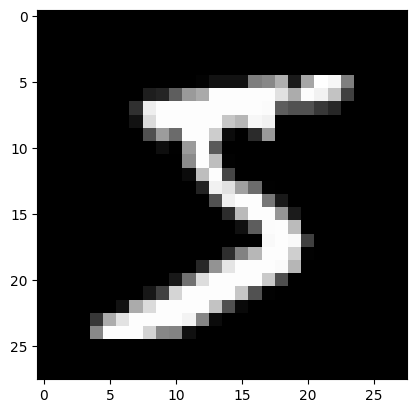

In [4]:
img, label = train_dataset[0]
# print(img)
plt.imshow(img.numpy().reshape(28,28), cmap='gray')

In [5]:
import torch.nn.functional as F

In [6]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [7]:
class ConvNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.layer1 = nn.Conv2d(1, 16, 3)
        self.layer2 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc = nn.Linear(800, 10)
        # nn.LazyLinear(10)

    def forward(self, x):
        # print(x.shape)
        x = F.relu(self.layer1(x))
        # print(x.shape)
        x = self.pool(x)
        # print(x.shape)
        x = F.relu(self.layer2(x))
        # print(x.shape)
        x = self.pool(x)
        # print(x.shape)
        x = self.flatten(x)
        # print(x.shape)
        return self.fc(x)

In [8]:
model = ConvNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
model(train_dataset[0][0].reshape(1,1,28,28))

tensor([[-0.0067,  0.0008,  0.0509, -0.0787,  0.1333, -0.0471, -0.0927,  0.0334,
          0.0172, -0.0188]], grad_fn=<AddmmBackward0>)

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        preds = model(X)
        loss = loss_fn(preds, y)

        # backpropagation - racunanje gradijenta
        loss.backward()
        # x_new = x - lr * grad
        optimizer.step()
        # necemo da sabiramo sve gradijente
        optimizer.zero_grad()

In [11]:
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        num_same = 0
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()

            if len(outputs.shape) == 1: # accuracy za dve klase
                preds = outputs > 0
                num_same += sum(preds == y).item()
            else:
                _, indices = torch.max(outputs, 1) # vise klasa - maks po dimenziji 1 jer je outputs.shape = (batch_size, num_classes)
                num_same += sum(indices == y).item()

        print(f'Average loss: {total_loss / len(dataloader.dataset)}')
        print(f'Accuracy: {num_same / len(dataloader.dataset)}')

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

num_epochs = 1
for epoch in range(num_epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer, device)
    test_loop(test_dataloader, model, loss_fn, device)

Average loss: 0.0021744779424741865
Accuracy: 0.9778


In [13]:
model.to(device)

ConvNet(
  (layer1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (layer2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=800, out_features=10, bias=True)
)

Predicted class: 7
Real class: tensor([7], device='cuda:0')
Predicted class: 2
Real class: tensor([2], device='cuda:0')
Predicted class: 1
Real class: tensor([1], device='cuda:0')
Predicted class: 0
Real class: tensor([0], device='cuda:0')
Predicted class: 4
Real class: tensor([4], device='cuda:0')
Predicted class: 1
Real class: tensor([1], device='cuda:0')
Predicted class: 4
Real class: tensor([4], device='cuda:0')
Predicted class: 9
Real class: tensor([9], device='cuda:0')
Predicted class: 5
Real class: tensor([5], device='cuda:0')
Predicted class: 9
Real class: tensor([9], device='cuda:0')
Predicted class: 0
Real class: tensor([0], device='cuda:0')
Predicted class: 6
Real class: tensor([6], device='cuda:0')
Predicted class: 9
Real class: tensor([9], device='cuda:0')
Predicted class: 0
Real class: tensor([0], device='cuda:0')
Predicted class: 1
Real class: tensor([1], device='cuda:0')
Predicted class: 5
Real class: tensor([5], device='cuda:0')
Predicted class: 9
Real class: tensor([9

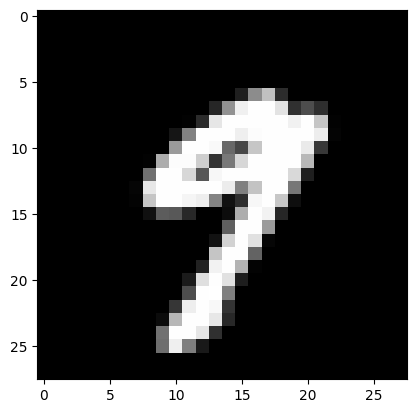

In [16]:
test_dataloader = DataLoader(test_dataset, batch_size=1)

for i, (X, y) in enumerate(test_dataloader):
    X, y = X.to(device), y.to(device)
    preds = model(X)
    print(f'Predicted class: {torch.argmax(preds)}')
    print(f'Real class: {y}')
    plt.imshow(X.cpu().numpy().reshape(28,28), cmap='gray')
    if i == 20:
        break